In [1]:
!pip install forex-python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

from sklearn.feature_selection import RFE

from dataset import Dataset


In [3]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [4]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [5]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [6]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [7]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [8]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [9]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [10]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [11]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [12]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [14]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [15]:
df_init = api_to_df('https://justjoin.it/api/offers')

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12828 entries, 0 to 12827
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    12828 non-null  object
 1   street                   12826 non-null  object
 2   city                     12828 non-null  object
 3   country_code             12824 non-null  object
 4   address_text             12828 non-null  object
 5   marker_icon              12828 non-null  object
 6   workplace_type           12828 non-null  object
 7   company_name             12828 non-null  object
 8   company_url              12828 non-null  object
 9   company_size             12828 non-null  object
 10  experience_level         12828 non-null  object
 11  latitude                 12828 non-null  object
 12  longitude                12828 non-null  object
 13  published_at             12828 non-null  object
 14  remote_interview         12828 non-nul

## Select the subset of the data - only "data" marker icon

In [16]:
# Limit observations to those that have flag 'data'
df_data = df_init[df_init['marker_icon'] == 'data']
df_data.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [17]:
json_data = []

In [18]:
offers = list(df_data.id)

In [19]:
len(offers)

1219

In [20]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

In [21]:
df_data_offers = pd.DataFrame(json_data)
# to_csv_date(df_data_offers, 'df_data_offers')

In [22]:
df_data_offers.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    1219 non-null   object
 2   street                   1219 non-null   object
 3   city                     1219 non-null   object
 4   country_code             1218 non-null   object
 5   address_text             1219 non-null   object
 6   marker_icon              1219 non-null   object
 7   workplace_type           1219 non-null   object
 8   company_name             1219 non-null   object
 9   company_url              1219 non-null   object
 10  company_size             1219 non-null   object
 11  experience_level         1219 non-null   object
 12  latitude                 1219 non-null   object
 13  longitude                1219 non-null   object
 14  apply_url                812 non-null   

In [23]:
df_data_offers.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    1219 non-null   object
 2   street                   1219 non-null   object
 3   city                     1219 non-null   object
 4   country_code             1218 non-null   object
 5   address_text             1219 non-null   object
 6   marker_icon              1219 non-null   object
 7   workplace_type           1219 non-null   object
 8   company_name             1219 non-null   object
 9   company_url              1219 non-null   object
 10  company_size             1219 non-null   object
 11  experience_level         1219 non-null   object
 12  latitude                 1219 non-null   object
 13  longitude                1219 non-null   object
 14  apply_url                812 non-null   

In [24]:
df_employment_types = df_data_offers['employment_types'].apply(pd.Series)
df_employment_types.sample()

df_employment_type_1 = df_employment_types[0].apply(pd.Series, dtype='object')
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_1['type'].unique()

df_employment_type_2 = df_employment_types[1].apply(pd.Series, dtype='object')
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

df_no_employment = df_data_offers.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.info()

# df_employment['type']= label_encoder.fit_transform(df_employment['type'])
type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
df_employment['type'] = df_employment['type'].map(type_map)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   apply_body               0 non-null      object 
 1   title                    1482 non-null   object 
 2   street                   1482 non-null   object 
 3   city                     1482 non-null   object 
 4   country_code             1481 non-null   object 
 5   address_text             1482 non-null   object 
 6   marker_icon              1482 non-null   object 
 7   workplace_type           1482 non-null   object 
 8   company_name             1482 non-null   object 
 9   company_url              1482 non-null   object 
 10  company_size             1482 non-null   object 
 11  experience_level         1482 non-null   object 
 12  latitude                 1482 non-null   object 
 13  longitude                1482 non-null   object 
 14  apply_url               

In [25]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

df_pln = pd.concat([df_with_salary, df_no_salary])
df_pln.reset_index(drop=True, inplace = True)
df_pln.info()

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_37744/111473866.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   apply_body               0 non-null      object 
 1   title                    1482 non-null   object 
 2   street                   1482 non-null   object 
 3   city                     1482 non-null   object 
 4   country_code             1481 non-null   object 
 5   address_text             1482 non-null   object 
 6   marker_icon              1482 non-null   object 
 7   workplace_type           1482 non-null   object 
 8   company_name             1482 non-null   object 
 9   company_url              1482 non-null   object 
 10  company_size             1482 non-null   object 
 11  experience_level         1482 non-null   object 
 12  latitude                 1482 non-null   object 
 13  longitude                1482 non-null   object 
 14  apply_url               

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_37744/111473866.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)


## Dealing with salaries

In [26]:
# extract rows with no salary information
df_no_salaries = df_pln[df_pln['to'].isna()].reset_index(drop=True)
df_no_salaries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   apply_body               0 non-null      object 
 1   title                    490 non-null    object 
 2   street                   490 non-null    object 
 3   city                     490 non-null    object 
 4   country_code             490 non-null    object 
 5   address_text             490 non-null    object 
 6   marker_icon              490 non-null    object 
 7   workplace_type           490 non-null    object 
 8   company_name             490 non-null    object 
 9   company_url              490 non-null    object 
 10  company_size             490 non-null    object 
 11  experience_level         490 non-null    object 
 12  latitude                 490 non-null    object 
 13  longitude                490 non-null    object 
 14  apply_url                3

In [27]:
# extract rows with salary information
df_salaries = df_pln[df_pln['to'].notna()].reset_index(drop=True)
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   apply_body               0 non-null      object 
 1   title                    992 non-null    object 
 2   street                   992 non-null    object 
 3   city                     992 non-null    object 
 4   country_code             991 non-null    object 
 5   address_text             992 non-null    object 
 6   marker_icon              992 non-null    object 
 7   workplace_type           992 non-null    object 
 8   company_name             992 non-null    object 
 9   company_url              992 non-null    object 
 10  company_size             992 non-null    object 
 11  experience_level         992 non-null    object 
 12  latitude                 992 non-null    object 
 13  longitude                992 non-null    object 
 14  apply_url                6

In [28]:
df_salaries_sorted = df_salaries.sort_values(by='from', ascending=True)
df_salaries_sorted.head()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,company_logo_url,banner_url,skills,remote,multilocation,company_profile,type,from,to,currency
5,None,Analityk Danych,AL. Niepodległości 188b,Warszawa,PL,"AL. Niepodległości 188b, Warszawa",data,partly_remote,OPI PIB,http://www.opi.org.pl,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 3}, {'name': 'Oracle...",False,"[{'slug': 'opi-pib-analityk-danych-warszawa', ...",NaN,0,4000.0,8000.0,pln
991,None,No code Developer,-,Kraków,PL,"-, Kraków",data,remote,Implemo,https://implemo.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Make', 'level': 3}, {'name': 'IFTTT...",True,[{'slug': 'implemo-no-code-developer-warszawa'...,NaN,1,4500.0,6000.0,pln
989,None,No code Developer,-,Poznań,PL,"-, Poznań",data,remote,Implemo,https://implemo.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Make', 'level': 3}, {'name': 'IFTTT...",True,[{'slug': 'implemo-no-code-developer-warszawa'...,NaN,1,4500.0,6000.0,pln
988,None,No code Developer,-,Wrocław,PL,"-, Wrocław",data,remote,Implemo,https://implemo.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Make', 'level': 3}, {'name': 'IFTTT...",True,[{'slug': 'implemo-no-code-developer-warszawa'...,NaN,1,4500.0,6000.0,pln
170,None,No code Developer,-,Warszawa,PL,"-, Warszawa",data,remote,Implemo,https://implemo.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Make', 'level': 3}, {'name': 'IFTTT...",True,[{'slug': 'implemo-no-code-developer-warszawa'...,NaN,1,4500.0,6000.0,pln


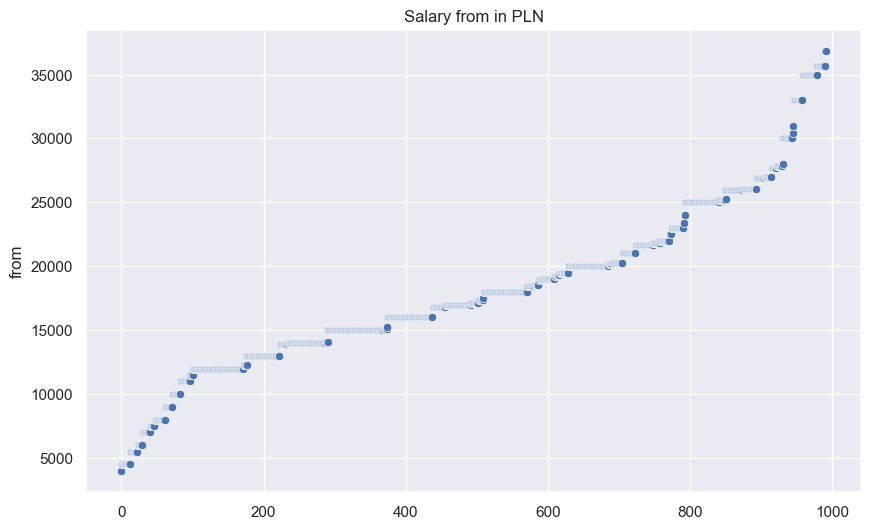

In [29]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.scatterplot(x=np.arange(len(df_salaries_sorted)), y=df_salaries_sorted['from'])
plot.set_title('Salary from in PLN')

plt.show()

### Split data into train and test set

In [30]:
# X = df_salaries.drop(columns=['from', 'to'])
# y = df_salaries[['from', 'to']]

In [31]:
train_data, test_data = train_test_split(df_salaries, test_size=0.3)

In [32]:
train_data.sample(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,company_logo_url,banner_url,skills,remote,multilocation,company_profile,type,from,to,currency
95,None,Database Administrator,Aleje Jerozolimskie,Warszawa,PL,"Aleje Jerozolimskie, Warszawa",data,remote,Link Group,http://linkgroup.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 5}, {'name': '...",True,[{'slug': 'link-group-database-administrator-w...,"{'url': '/brands/story/link-group', 'short_des...",1,25200.0,33600.0,pln
80,None,Analityk Hurtowni Danych,Centrum,Warszawa,PL,"Centrum, Warszawa",data,remote,Craon.pl,https://www.craon.pl,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'ETL', 'level': 3}, {'name': 'SQL', ...",True,[{'slug': 'craon-pl-analityk-hurtowni-danych-k...,NaN,1,18480.0,23520.0,pln
493,None,(Senior) Data Engineer,Centrum,Wrocław,PL,"Centrum, Wrocław",data,remote,Netguru,http://netguru.com,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Data Engineering', 'level': 4}, {'n...",True,[{'slug': 'netguru-senior-data-engineer-fe228a...,"{'url': '/brands/story/netguru', 'short_descri...",1,20000.0,32700.0,pln
288,None,ETL/SQL Report Developer,Centrum,Łódź,PL,"Centrum, Łódź",data,remote,DPDgroup IT Solutions,https://dpdgroupitsolutions.pl/,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'SQL', 'level': 5}, {'name': 'Englis...",True,[{'slug': 'dpdgroup-it-solutions-etl-sql-repor...,"{'url': '/brands/story/dpdgroup-it-solutions',...",1,12000.0,18000.0,pln
464,None,Mid/Senior Data Engineer,centrum,Kraków,PL,"centrum, Kraków",data,remote,INSIGHT,http://nexergroup.com,...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'ETL process', 'level': 3}, {'name':...",True,[{'slug': 'insight-mid-senior-data-engineer-8e...,NaN,1,19000.0,30500.0,pln


### Dealing with skills

In [33]:
print(train_data['skills'].sample())

959    [{'name': 'Big Data', 'level': 4}, {'name': 'D...
Name: skills, dtype: object


In [34]:
# Putting all skills into one column

old_train_data = train_data.to_dict(orient='records')
new_train_data = []

for index, skills_list in enumerate(train_data['skills']):
    for skill in skills_list:
        new_row = old_train_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_train_data.append(new_row)

old_test_data = test_data.to_dict(orient='records')
new_test_data = []

for index, skills_list in enumerate(test_data['skills']):
    for skill in skills_list:
        new_row = old_test_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_test_data.append(new_row)

In [35]:
train_df = pd.DataFrame(new_train_data)
test_df = pd.DataFrame(new_test_data)

In [36]:
train_df.sample()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,skills,remote,multilocation,company_profile,type,from,to,currency,skill_name,skill_level
4484,None,Remote SQL Server Database Administrator,-,Olsztyn,PL,"-, Olsztyn",data,remote,Qurate Retail Group GBS,http://QurateRetailGroup.com,...,"[{'name': 'SQL Server', 'level': 3}, {'name': ...",True,[{'slug': 'qurate-retail-group-gbs-remote-sql-...,{'url': '/brands/story/qurate-retail-group-glo...,0,16000.0,20000.0,pln,Powershell,3


In [37]:
train_df.skill_name.unique()

array(['Databases', 'English', 'Oracle', 'SQL Server', 'MySQL', 'MariaDB',
       'Eloquence', 'AIX', 'Windows', 'DevOps', 'R', 'shiny', 'Git',
       'SQL', 'Python', 'Julia', 'MLOps', 'Machine Learning', 'JIRA',
       'Confluence', 'ms teams', 'MS Excel', 'powerPoint',
       'data governance', 'Risk Management', 'Databricks', 'Azure',
       'NoSQL', 'AWS', 'GCP', 'TimeXtender', 'MS Data', 'AWS DataOps',
       'SQL/Non-relational', 'Data modeling', 'ETL tools',
       'Data Warehousing', 'Spark', 'PostgreSQL', 'Java', 'Eclipse',
       'GitLab', 'Jenkins', 'Tomcat', 'ETL', 'Niemiecki', 'master data',
       'SAP', 'SAP MM', 'NumPy', 'Pandas', 'scikit-learn', 'Docker',
       'Apache Airflow', 'Bash', 'Jupyter Notebook', 'Data Engineering',
       'Google Cloud Platform', 'GitHub', 'CI/CD', 'Python/Go',
       'Docker/Kubernates', 'ETL process', 'DATA MODELLING', 'Power BI',
       'Data Bricks', 'Azure Data Factory', 'Data Warehouse', 'PL/SQL',
       'baza danych Oracle', 'MS SQL

In [38]:
train_df.skill_name.nunique()

342

In [39]:
# Po co to?

clean_train_df = train_df.copy()
clean_train_df = standardize_text(clean_train_df, "title")
clean_train_df = standardize_text(clean_train_df, "skill_name")

clean_test_df = test_df.copy()
clean_test_df = standardize_text(clean_test_df, "title")
clean_test_df = standardize_text(clean_test_df, "skill_name")

In [40]:
clean_train_df.head(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,skills,remote,multilocation,company_profile,type,from,to,currency,skill_name,skill_level
0,None,database administrator,-,Bielsko-Biała,PL,"-, Bielsko-Biała",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,0,18000.0,23000.0,pln,databases,4
1,None,database administrator,-,Bielsko-Biała,PL,"-, Bielsko-Biała",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,0,18000.0,23000.0,pln,english,4
2,None,database administrator,-,Bielsko-Biała,PL,"-, Bielsko-Biała",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,0,18000.0,23000.0,pln,oracle,4
3,None,database administrator,-,Bielsko-Biała,PL,"-, Bielsko-Biała",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,0,18000.0,23000.0,pln,sql server,3
4,None,database administrator,-,Bielsko-Biała,PL,"-, Bielsko-Biała",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,0,18000.0,23000.0,pln,mysql,1


In [41]:
top_values = clean_train_df['skill_name'].value_counts().head(30)
top_30_skills = list(top_values.index)

In [42]:
print(top_30_skills)

['python', 'sql', 'aws', 'english', 'java', 'etl', 'power bi', 'big data', 'nosql', 'snowflake', 'cloud', 'devops', 'databases', 'sql server', 'machine learning', 'spark', 'mysql', 'oracle', 'dax', 'ci/cd', 'data warehouse', 'azure', 'kafka', 'docker', 'linux', 't-sql', 'git', 'javascript', 'airflow', 'dwh']


In [43]:
with open('output.txt', 'w') as file:
    for item in top_30_skills:
        file.write(str(item) + '\n')

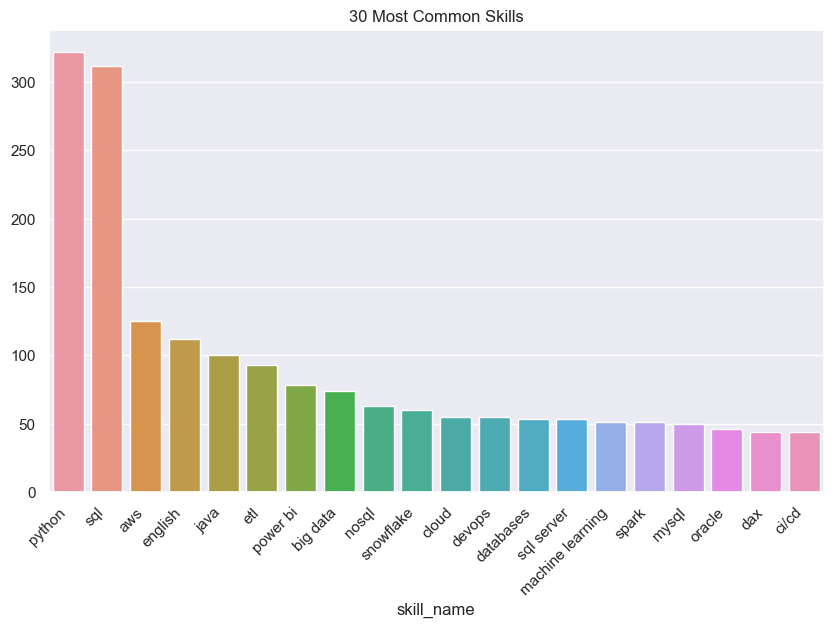

In [44]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_train_df['skill_name'].value_counts().iloc[:20].index, y=clean_train_df['skill_name'].value_counts().iloc[:20].values)
plot.set_title('30 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [45]:
common_skills_train = clean_train_df.copy()
mask = ~common_skills_train['skill_name'].isin(top_30_skills)
common_skills_train.loc[mask, 'skill_name'] = None

most_common_skills_train = common_skills_train.dropna(subset=['skill_name'])

In [46]:
common_skills_test = clean_test_df.copy()
mask = ~common_skills_test['skill_name'].isin(top_30_skills)
common_skills_test.loc[mask, 'skill_name'] = None

most_common_skills_test = common_skills_test.dropna(subset=['skill_name'])

In [47]:
most_common_skills_train.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'multilocation', 'company_profile',
       'type', 'from', 'to', 'currency', 'skill_name', 'skill_level'],
      dtype='object')

In [278]:
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

encoder = OneHotEncoder(handle_unknown='ignore')

# Train data
encoder.fit(most_common_skills_train[['skill_name']])
dummies_train = encoder.transform(most_common_skills_train[['skill_name']])
dummies_test = encoder.transform(most_common_skills_test[['skill_name']])

multiplier_train = most_common_skills_train['skill_level'].values
multiplier_test = most_common_skills_test['skill_level'].values

dummies_train_df = pd.DataFrame.sparse.from_spmatrix(dummies_train, columns=encoder.get_feature_names_out(['skill_name']))
dummies_test_df = pd.DataFrame.sparse.from_spmatrix(dummies_test, columns=encoder.get_feature_names_out(['skill_name']))

dummies_train_df = dummies_train_df.mul(multiplier_train, axis=0)
dummies_test_df = dummies_test_df.mul(multiplier_test, axis=0)

# Dołączanie kolumn dummies
aggregated_train = pd.concat([most_common_skills_train, dummies_train_df], axis=1)
aggregated_test = pd.concat([most_common_skills_test, dummies_test_df], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_train = aggregated_train.drop(['skills', 'skill_name', 'skill_level'], axis=1)
aggregated_test = aggregated_test.drop(['skills', 'skill_name', 'skill_level'], axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_train = aggregated_train.groupby('id', as_index=False).agg(custom_agg)
aggregated_test = aggregated_test.groupby('id', as_index=False).agg(custom_agg)

1.2.2


In [279]:


joblib.dump(encoder, f"one_hot_encoder{scikit_version}.pkl")

['one_hot_encoder1.2.2.pkl']

In [49]:
aggregated_train.sample(15)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_name_mysql,skill_name_nosql,skill_name_oracle,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql
578,vm-pl-junior-mid-pl-sql-developer-with-english...,None,junior/mid pl/sql developer with english,centrum,Kraków,PL,"centrum, Kraków",data,remote,VM.PL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
437,pcss-regular-data-scientist-python-lubon,None,regular data scientist (python),-,Luboń,PL,"-, Luboń",data,partly_remote,PCSS,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
317,itds-data-warehouse-analyst-banking-ad92f53b-4...,None,data warehouse analyst - banking 💰,Złota 59,Warszawa,PL,"Złota 59, Warszawa",data,partly_remote,ITDS,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
328,jit-team-remote-senior-data-engineer-warszawa,None,remote senior data engineer,Przyokopowa 33,Warszawa,PL,"Przyokopowa 33, Warszawa",data,remote,Jit Team,...,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
546,sky-gate-machine-learning-developer-poznan,None,machine learning developer,Centrum,Poznań,PL,"Centrum, Poznań",data,remote,Mindpal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,netguru-senior-data-engineer-1226b73b-cdea-483...,None,(senior) data engineer,Centrum,Rzeszów,PL,"Centrum, Rzeszów",data,remote,Netguru,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510,qurate-retail-group-gbs-remote-sql-server-data...,None,remote sql server database administrator,-,Gdańsk,PL,"-, Gdańsk",data,remote,Qurate Retail Group GBS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354,limango-polska-it-professional-transitioning-r...,None,it professional transitioning,-,Rzeszów,PL,"-, Rzeszów",data,remote,Limango Polska,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,crimson-panda-sql-data-engineer,None,sql data engineer,gdansk,Gdańsk,PL,"gdansk, Gdańsk",data,remote,Crimson Panda,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,cloudfide-power-bi-developer-lodz,None,power bi developer,Centrum,Łódź,PL,"Centrum, Łódź",data,remote,CLOUDFIDE,...,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0


In [50]:
aggregated_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype               
---  ------                       --------------  -----               
 0   id                           586 non-null    object              
 1   apply_body                   0 non-null      object              
 2   title                        586 non-null    object              
 3   street                       586 non-null    object              
 4   city                         586 non-null    object              
 5   country_code                 586 non-null    object              
 6   address_text                 586 non-null    object              
 7   marker_icon                  586 non-null    object              
 8   workplace_type               586 non-null    object              
 9   company_name                 586 non-null    object              
 10  company_url                  586 non-n

## Dealing with experience level - label encoding

In [51]:
aggregated_train['experience_level'].unique()

array(['senior', 'mid', 'junior'], dtype=object)

In [52]:
# label_encoder = preprocessing.LabelEncoder()
# aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])
level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
aggregated_train['experience_level'] = aggregated_train['experience_level'].map(level_mapping)
aggregated_test['experience_level'] = aggregated_test['experience_level'].map(level_mapping)

In [53]:
aggregated_train['experience_level'].unique()

array([2, 1, 0])

### Dealing with same offers but from different cities

In [54]:
aggregated_train.head(20)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_name_mysql,skill_name_nosql,skill_name_oracle,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql
0,4it-solutions-pl-sql-developer-warszawa,None,pl/sql developer,Rondo Daszyńskiego,Warszawa,PL,"Rondo Daszyńskiego, Warszawa",data,partly_remote,4IT Solutions,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acaisoft-data-tech-lead,None,data tech lead,Puławska 182,Warszawa,PL,"Puławska 182, Warszawa",data,remote,Acaisoft,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,acaisoft-senior-data-engineer-c8be7573-e06d-40...,None,senior data engineer,Puławska 182,Warszawa,PL,"Puławska 182, Warszawa",data,remote,Acaisoft,...,1.0,0.0,3.0,0.0,8.0,0.0,0.0,5.0,3.0,0.0
3,accenture-data-transformation-consultant,None,data transformation consultant,Sienna 39,Warszawa,PL,"Sienna 39, Warszawa",data,remote,Accenture,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,accenture-data-transformation-consultant-wroclaw,None,data transformation consultant,Strzegomska 142A,Wrocław,PL,"Strzegomska 142A, Wrocław",data,remote,Accenture,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
5,actaware-data-engineer,None,data engineer,Aleje Jerozolimskie,Warszawa,PL,"Aleje Jerozolimskie, Warszawa",data,partly_remote,ActAware,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0
6,adastra-data-governance-specialist-banska-byst...,None,data governance specialist,-,Bańska Bystrzyca,SK,"-, Bańska Bystrzyca",data,remote,ADASTRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,adastra-data-governance-specialist-bratyslawa,None,data governance specialist,-,Bratysława,SK,"-, Bratysława",data,remote,ADASTRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,adastra-data-governance-specialist-brno,None,data governance specialist,Centrum,Brno,CZ,"Centrum, Brno",data,remote,ADASTRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,adastra-data-governance-specialist-koszyce,None,data governance specialist,-,Koszyce,SK,"-, Koszyce",data,remote,ADASTRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Konwertowanie DataFrame na słownik
train_dict = aggregated_train.to_dict(orient='records')

# Nowa lista, do której dodamy scalone wiersze w formie słowników
merged_data = []

# Iteracja przez słowniki
for index, record in enumerate(train_dict):
    if index == 0:
        # Pierwszy rekord dodajemy od razu, bo nie ma poprzedniego do porównania
        merged_data.append(record)
    else:
        # Sprawdzamy, czy 'title' i 'company_name' są takie same jak w poprzednim rekordzie
        if (record['title'] == train_dict[index - 1]['title']) and (record['company_name'] == train_dict[index - 1]['company_name']):
            # Jeśli tak, to scalamy rekordy i zachowujemy wartość 'salary' z rekordu wcześniejszego
            merged_record = record.copy()
            merged_data[-1] = merged_record  # Zamień ostatni rekord w merged_data na scalony rekord
        else:
            # Jeśli nie, to dodajemy rekord do merged_data
            merged_data.append(record)

merged_train = pd.DataFrame(merged_data)
merged_test = aggregated_test.copy()

merged_train.head()

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_name_mysql,skill_name_nosql,skill_name_oracle,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql
0,4it-solutions-pl-sql-developer-warszawa,None,pl/sql developer,Rondo Daszyńskiego,Warszawa,PL,"Rondo Daszyńskiego, Warszawa",data,partly_remote,4IT Solutions,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acaisoft-data-tech-lead,None,data tech lead,Puławska 182,Warszawa,PL,"Puławska 182, Warszawa",data,remote,Acaisoft,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,acaisoft-senior-data-engineer-c8be7573-e06d-40...,None,senior data engineer,Puławska 182,Warszawa,PL,"Puławska 182, Warszawa",data,remote,Acaisoft,...,1.0,0.0,3.0,0.0,8.0,0.0,0.0,5.0,3.0,0.0
3,accenture-data-transformation-consultant-wroclaw,None,data transformation consultant,Strzegomska 142A,Wrocław,PL,"Strzegomska 142A, Wrocław",data,remote,Accenture,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,actaware-data-engineer,None,data engineer,Aleje Jerozolimskie,Warszawa,PL,"Aleje Jerozolimskie, Warszawa",data,partly_remote,ActAware,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0


## Dealing with 'workplace_type', 'country_code'

In [56]:
merged_train['workplace_type'].unique()

array(['partly_remote', 'remote', 'office'], dtype=object)

In [57]:
merged_train['country_code'].unique()

array(['PL', 'CZ', 'RO', 'EE'], dtype=object)

In [58]:
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, 'None': 10,
       'EE': 11}

merged_train['workplace_type'] =merged_train['workplace_type'].map(workplace_mapping)
merged_train['country_code'] = merged_train['country_code'].map(country_mapping)
merged_train['country_code'] = merged_train['country_code'].fillna(10)

merged_test['workplace_type'] =merged_test['workplace_type'].map(workplace_mapping)
merged_test['country_code'] = merged_test['country_code'].map(country_mapping)
merged_test['country_code'] = merged_test['country_code'].fillna(10)

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 30 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [59]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_train = merged_train[merged_train['company_size'].str.contains('-')][['company_size']]
company_size_test = merged_test[merged_test['company_size'].str.contains('-')][['company_size']]
company_size_train

,company_size
4,11-50
8,51-200
9,1001 - 5000
14,60-80
23,20-30
41,10-20
42,70-80
43,30-40
54,51-100
66,50-100


In [60]:
company_size_train['company_size_1'] = company_size_train['company_size'].str.split('-').str[0]
company_size_train['company_size_2']  = company_size_train['company_size'].str.split('-').str[-1]

company_size_test['company_size_1'] = company_size_test['company_size'].str.split('-').str[0]
company_size_test['company_size_2']  = company_size_test['company_size'].str.split('-').str[-1]

In [61]:
company_size_train[company_size_train['company_size']=='-']
company_size_test[company_size_test['company_size']=='-']

,company_size,company_size_1,company_size_2


In [62]:
company_size_train = company_size_train[company_size_train['company_size'] != '-']
company_size_train[company_size_train['company_size']=='-']

company_size_test = company_size_test[company_size_test['company_size'] != '-']
company_size_test[company_size_test['company_size']=='-']

,company_size,company_size_1,company_size_2


In [63]:
# company_size_df = company_size_df.copy()
company_size_train['company_size_1'] = pd.to_numeric(company_size_train['company_size_1'])
company_size_train['company_size_2'] = pd.to_numeric(company_size_train['company_size_2'])
company_size_train['avg_company_size'] = (company_size_train['company_size_1'] + company_size_train['company_size_2']) / 2

company_size_train = company_size_train[['avg_company_size']]
company_size_train

,avg_company_size
4,30.5
8,125.5
9,3000.5
14,70.0
23,25.0
41,15.0
42,75.0
43,35.0
54,75.5
66,75.0


In [64]:
company_size_test['company_size_1'] = pd.to_numeric(company_size_test['company_size_1'])
company_size_test['company_size_2'] = pd.to_numeric(company_size_test['company_size_2'])
company_size_test['avg_company_size'] = (company_size_test['company_size_1'] + company_size_test['company_size_2']) / 2

company_size_test = company_size_test[['avg_company_size']]
company_size_test

,avg_company_size
9,125.5
10,125.5
11,125.5
12,3000.5
23,70.0
83,15.0
84,75.0
85,35.0
86,35.0
87,35.0


In [65]:
avg_company_size_train = pd.merge(merged_train, company_size_train, left_index=True, right_index=True, how = 'outer')
avg_company_size_test = pd.merge(merged_test, company_size_test, left_index=True, right_index=True, how = 'outer')

In [66]:
avg_company_size_train['company_size'] = avg_company_size_train['company_size'].apply(remove_mark)
avg_company_size_train['company_size'] = avg_company_size_train['company_size'].apply(remove_mark)
avg_company_size_test['company_size'] = avg_company_size_test['company_size'].apply(remove_mark)
avg_company_size_test['company_size'] = avg_company_size_test['company_size'].apply(remove_mark)
avg_company_size_train['company_size'].unique()

array(['40', '250', '6000', '1150', '200', '30', '51200', '10015000',
       '150', '100', '500', '6080', '60000', '1000', '80', '2030',
       '10000', '50', '300000', '300', '4', '16', '5000', '1020', '7080',
       '3040', '450', '190', '66.000', '17', '51100', '1400', '2800',
       '50100', '120', '1125', '90', '2000', '63', '200250', '600', '650',
       '900', '460', '430', '400', '6070', '22200', '3060', '170', '1500',
       '280', '5060', '1140', '100200', '180'], dtype=object)

In [67]:
avg_company_size_train['company_size'] = pd.to_numeric(avg_company_size_train['company_size'])
avg_company_size_test['company_size'] = pd.to_numeric(avg_company_size_test['company_size'])

In [68]:
# avg_company_size_train['avg_company_size'] = avg_company_size_train.apply(
#     lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
#     axis=1
# ).astype('float')

# avg_company_size_test['avg_company_size'] = avg_company_size_test.apply(
#     lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
#     axis=1
# ).astype('float')

# Dla zbioru treningowego
avg_company_size_train['avg_company_size'] = avg_company_size_train['avg_company_size'].fillna(avg_company_size_train['company_size']).astype('float')

# Dla zbioru testowego
avg_company_size_test['avg_company_size'] = avg_company_size_test['avg_company_size'].fillna(avg_company_size_test['company_size']).astype('float')

In [69]:
avg_company_size_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 0 to 152
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           153 non-null    object 
 1   apply_body                   0 non-null      object 
 2   title                        153 non-null    object 
 3   street                       153 non-null    object 
 4   city                         153 non-null    object 
 5   country_code                 153 non-null    int64  
 6   address_text                 153 non-null    object 
 7   marker_icon                  153 non-null    object 
 8   workplace_type               153 non-null    int64  
 9   company_name                 153 non-null    object 
 10  company_url                  153 non-null    object 
 11  company_size                 153 non-null    float64
 12  experience_level             153 non-null    int64  
 13  latitude                 

In [70]:
# to_csv_date(df_avg_company_size,'offers_API_ready_to_analyze')

# BUILDING REGRESSION MODEL

In [71]:
train_reg = avg_company_size_train.copy()
test_reg = avg_company_size_test.copy()

In [72]:
train_reg.sample(5)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_name_nosql,skill_name_oracle,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql,avg_company_size
11,andea-software-consultant-rzeszow,None,software consultant,centrum,Rzeszów,0,"centrum, Rzeszów",data,1,Andea,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0
29,cloudfide-senior-data-engineer-wroclaw,None,senior data engineer,Centrum,Wrocław,0,"Centrum, Wrocław",data,0,CLOUDFIDE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
22,bytamic-solutions-senior-data-engineer,None,senior data engineer / etl,Prosta 20,Warszawa,0,"Prosta 20, Warszawa",data,0,Bytamic Solutions,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
82,itds-senior-ms-sql-developer-wroclaw,None,senior ms sql developer,Centrum,Wrocław,0,"Centrum, Wrocław",data,0,ITDS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
18,beliani-group-power-bi-developer-szczecin,None,power bi developer,Stanisława Więckowskiego 1b,Szczecin,0,"Stanisława Więckowskiego 1b, Szczecin",data,1,Beliani Group,...,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,100.0


In [180]:
# remove columns that won't be taken into consideration
train_reg_limit=train_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])
test_reg_limit=test_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])
train_reg_limit = train_reg_limit.reindex(sorted(train_reg_limit.columns), axis=1)
test_reg_limit = test_reg_limit.reindex(sorted(test_reg_limit.columns), axis=1)

In [183]:
train_reg_limit.head()

,avg_company_size,country_code,experience_level,from,remote,skill_name_airflow,skill_name_aws,skill_name_azure,skill_name_big data,skill_name_ci/cd,...,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql,to,type,workplace_type
0,40.0,0,2,16800.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20160.0,1.0,1
1,250.0,0,2,31000.0,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,38000.0,1.0,0
2,250.0,0,2,21000.0,True,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,5.0,3.0,0.0,26500.0,0.0,0
3,6000.0,0,1,13000.0,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,25000.0,0.0,0
4,30.5,0,1,12000.0,False,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,0.0,0.0,20000.0,1.0,1


In [184]:
# pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('svr', svr)])

In [185]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90)
scaler = StandardScaler()

In [186]:
X_train = train_reg_limit.drop(columns=['from', 'to'])
X_test = train_reg_limit.drop(columns=['from', 'to'])
y_train_from = train_reg_limit['from']
y_train_to = train_reg_limit['to']
y_test_from = train_reg_limit['from']
y_test_to = train_reg_limit['to']

In [187]:
X_train.shape

(153, 36)

In [188]:
lr = LinearRegression()
svr = SVR()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

In [189]:
pipeline_from = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('model', lr),
    ])


## Salafry_from: GridSeachCV and best model choose

In [190]:
param_grid = [
    {
        'model': [lr],
        'model__fit_intercept': [True, False],
        # Dodaj inne hiperparametry LinearRegression
    },
    {
        'model': [svr],
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf'],
        'model__epsilon': [0.1, 0.2, 0.3],
        'model__gamma': ['scale', 'auto'],
    },
    {
        'model': [rfr],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    {
        'model': [gbr],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 3, 4],
    },
]

In [191]:
grid_search_from = GridSearchCV(pipeline_from, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_from.fit(X_train, y_train_from)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('model', LinearRegression())]),
             param_grid=[{'model': [LinearRegression()],
                          'model__fit_intercept': [True, False]},
                         {'model': [SVR()], 'model__C': [0.1, 1.0, 10.0],
                          'model__epsilon': [0.1, 0.2, 0.3],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['linear', 'rbf']...
                                                          min_samples_split=10)],
                          'model__max_depth': [None, 10, 20],
                          'model__min_samples_leaf': [1, 2, 4],
                          'model__min_samples_split': [2, 5, 10],
                          'model__n_estimators': [100, 200, 300]},
                         {'model': [GradientBoostingRegressor()],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 4, 5],
                          'model__min_samples_split': [2, 3, 4],
                          'model__n_estimators': [100, 200, 300]}],
             scoring='neg_mean_squared_error')

In [192]:
best_params_from = grid_search_from.best_params_
best_model_from = grid_search_from.best_estimator_

In [193]:
best_params_from

{'model': RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10),
 'model__max_depth': 10,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10,
 'model__n_estimators': 100}

In [194]:
best_model_from.fit(X_train, y_train_from)

# Ocena modelu na danych testowych
test_score_from = best_model_from.score(X_test, y_test_from)

In [195]:
test_score_from

0.6750927175081931

In [196]:
def test_model(x_test, y_test, model):
    

    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    
    print(
        f'Model: {model}\n\n',
        f'Mean Squared error: {mse}'
        )
    return (model, mse)

In [197]:
test_model(X_test, y_test_from, best_model_from)

Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=4,
                                       min_samples_split=10))])

 Mean Squared error: 13950381.195186974


(Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                 ('model',
                  RandomForestRegressor(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10))]),
 13950381.195186974)

### Salary_from: comparision of real and predicted y for train and test set

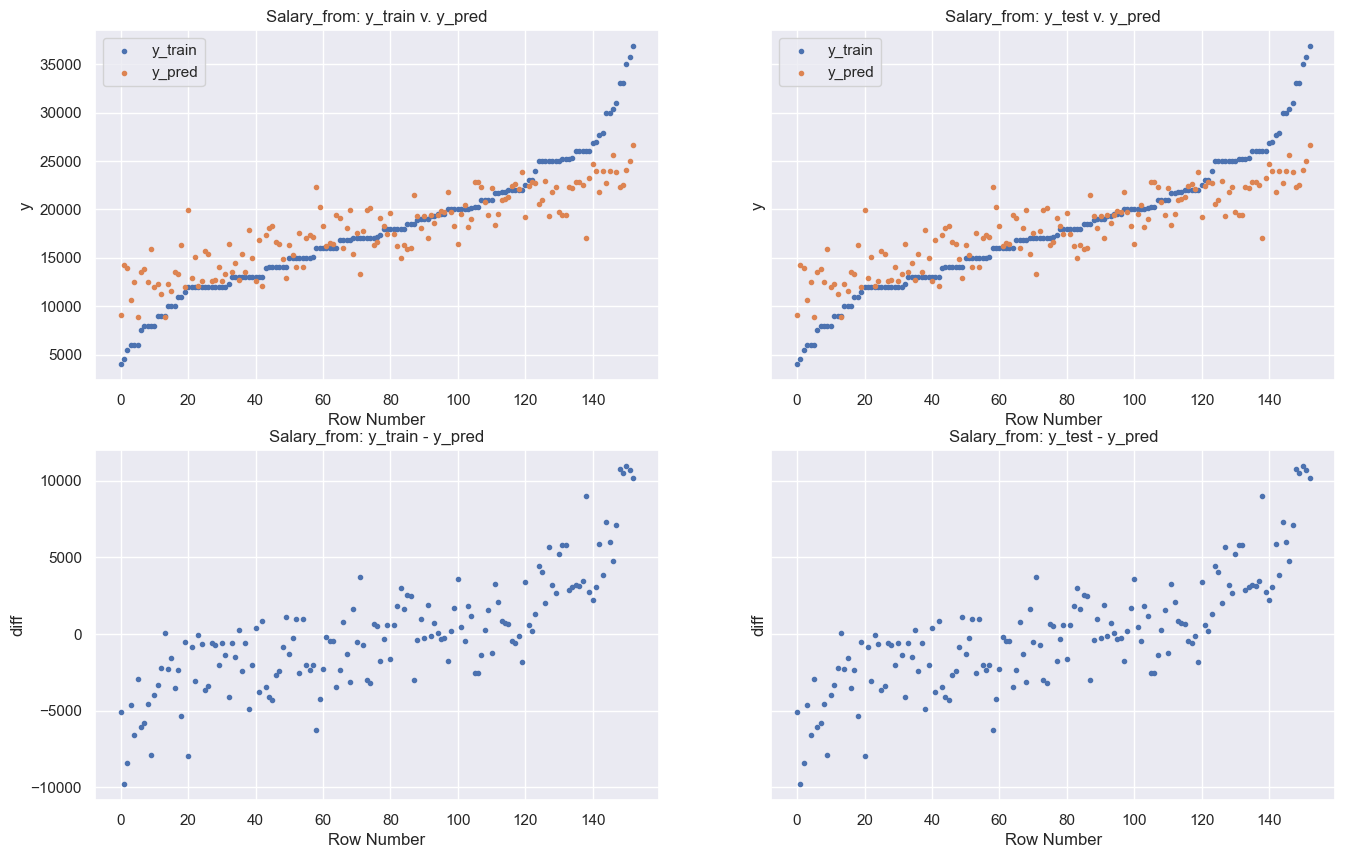

In [198]:
# df with real and predicted y for the train set
y_pred_train_from = best_model_from.predict(X_train)
df_train_from = {'y_train': y_train_from, 'y_pred_train': y_pred_train_from, 'train_diff': y_train_from-y_pred_train_from}
df_train_from = pd.DataFrame(df_train_from)
df_train_from.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test_from = best_model_from.predict(X_test)
df_test_from = {'y_test': y_test_from, 'y_pred_test': y_pred_test_from, 'test_diff': y_test_from-y_pred_test_from}
df_test_from = pd.DataFrame(df_test_from)
df_test_from.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train_from = range(len(df_train_from))
length_test_from = range(len(df_test_from))

# Salary_from: y_train v. y_pred
axis[0, 0].scatter(length_train_from, df_train_from['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train_from, df_train_from['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary_from: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary_from: y_train - y_pred
axis[1, 0].scatter(length_train_from, df_train_from['train_diff'], marker = '.')
axis[1, 0].set_title("Salary_from: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary_from: y_test v. y_pred
axis[0, 1].scatter(length_test_from, df_test_from['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test_from, df_test_from['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary_from: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary_from: y_test - y_pred
axis[1, 1].scatter(length_test_from, df_test_from['test_diff'], marker = '.')
axis[1, 1].set_title("Salary_from: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()

### Salary_to: Random Forest + **GridSearchCV**

In [199]:
pipeline_from = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('model', lr),
    ])

In [200]:
param_grid = [
    {
        'model': [lr],
        'model__fit_intercept': [True, False],
        # Dodaj inne hiperparametry LinearRegression
    },
    {
        'model': [svr],
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf'],
        'model__epsilon': [0.1, 0.2, 0.3],
        'model__gamma': ['scale', 'auto'],
    },
    {
        'model': [rfr],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    {
        'model': [gbr],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 3, 4],
    },
]

In [201]:
grid_search_to = GridSearchCV(pipeline_from, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_to.fit(X_train, y_train_to)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('model', LinearRegression())]),
             param_grid=[{'model': [LinearRegression()],
                          'model__fit_intercept': [True, False]},
                         {'model': [SVR()], 'model__C': [0.1, 1.0, 10.0],
                          'model__epsilon': [0.1, 0.2, 0.3],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['linear', 'rbf']...
                          'model__min_samples_leaf': [1, 2, 4],
                          'model__min_samples_split': [2, 5, 10],
                          'model__n_estimators': [100, 200, 300]},
                         {'model': [GradientBoostingRegressor(learning_rate=0.01,
                                                              min_samples_split=3,
                                                              n_estimators=200)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 4, 5],
                          'model__min_samples_split': [2, 3, 4],
                          'model__n_estimators': [100, 200, 300]}],
             scoring='neg_mean_squared_error')

### Salary_to: comparision of real and predicted y for train and test set

In [202]:
best_params_to = grid_search_to.best_params_
best_model_to = grid_search_to.best_estimator_

In [203]:
best_params_to

{'model': GradientBoostingRegressor(learning_rate=0.01, min_samples_split=3,
                           n_estimators=200),
 'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__min_samples_split': 3,
 'model__n_estimators': 200}

In [204]:
best_model_to.fit(X_train, y_train_to)

# Ocena modelu na danych testowych
test_score_to = best_model_to.score(X_test, y_test_to)

In [205]:
test_score_to

0.6872376099841251

In [206]:
test_model(X_test, y_test_to, best_model_to)

Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           min_samples_split=3,
                                           n_estimators=200))])

 Mean Squared error: 19951083.357745778


(Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                 ('model',
                  GradientBoostingRegressor(learning_rate=0.01,
                                            min_samples_split=3,
                                            n_estimators=200))]),
 19951083.357745778)

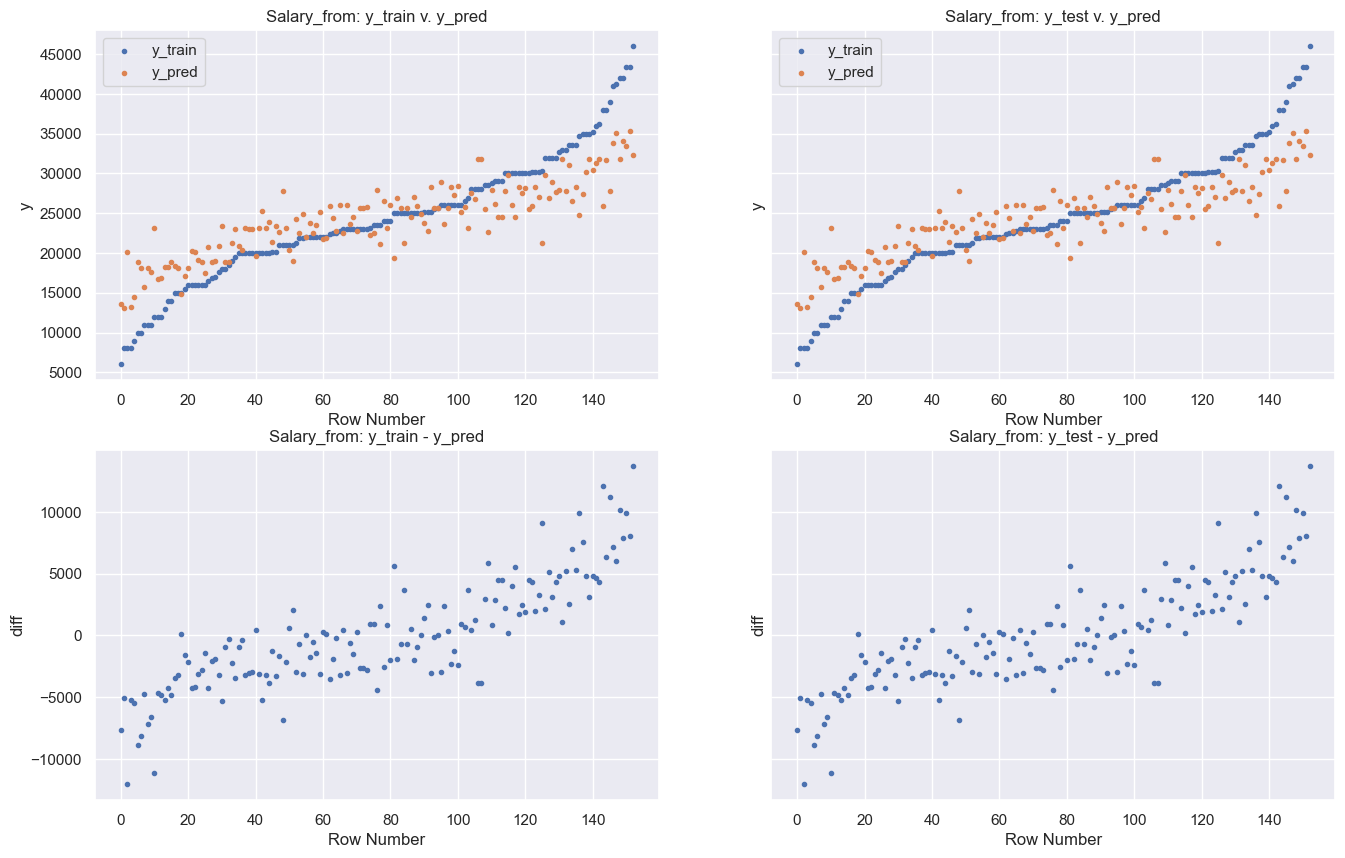

In [207]:
# df with real and predicted y for the train set
y_pred_train_to = best_model_to.predict(X_train)
df_train_to = {'y_train': y_train_to, 'y_pred_train': y_pred_train_to, 'train_diff': y_train_to-y_pred_train_to}
df_train_to = pd.DataFrame(df_train_to)
df_train_to.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test_to = best_model_to.predict(X_test)
df_test_to = {'y_test': y_test_to, 'y_pred_test': y_pred_test_to, 'test_diff': y_test_to-y_pred_test_to}
df_test_to = pd.DataFrame(df_test_to)
df_test_to.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train_to = range(len(df_train_to))
length_test_to = range(len(df_test_to))

# Salary_from: y_train v. y_pred
axis[0, 0].scatter(length_train_to, df_train_to['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train_to, df_train_to['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary_from: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary_from: y_train - y_pred
axis[1, 0].scatter(length_train_to, df_train_to['train_diff'], marker = '.')
axis[1, 0].set_title("Salary_from: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary_from: y_test v. y_pred
axis[0, 1].scatter(length_test_to, df_test_to['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test_to, df_test_to['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary_from: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary_from: y_test - y_pred
axis[1, 1].scatter(length_test_to, df_test_to['test_diff'], marker = '.')
axis[1, 1].set_title("Salary_from: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()

##MAE distribution

In [208]:
# mae_from = []

# for i in range(1000):

#     model_from = RandomForestRegressor(max_depth = None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
#     # model_from = RandomForestRegressor(best_model_from.get_params())
#     model_from.fit(X_train_from, y_train_from)

#     mae_from.append(mean_absolute_error(y_test_from, model_from.predict(X_test_from)))

# sns.set_style("darkgrid")
# sns.histplot(mae_from)

In [209]:
# from sklearn import model_selection
# mae_to = []

# for i in range(1000):

#     model_to = RandomForestRegressor(max_depth = 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)
#     # model_to = RandomForestRegressor(best_model_to.get_params())
#     model_to.fit(X_train_to, y_train_to)

#     mae_to.append(mean_absolute_error(y_test_to, model_to.predict(X_test_to)))

# sns.set_style("darkgrid")
# sns.histplot(mae_to)

In [276]:
# saving model
joblib.dump(best_model_from, f"best_model_from_{scikit_version}.pkl")
joblib.dump(best_model_to, f"best_model_to_{scikit_version}.pkl")

1.2.2


['best_model_to_1.2.2.pkl']

# Reading job offer and preparing the data

In [260]:
job_offer = 'https://justjoin.it/offers/hl-tech-data-engineer'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [261]:
response = requests.get(job_offer_api)
job_data = response.json()

In [262]:
job_data

{'apply_body': None,
 'title': 'Data Engineer',
 'street': 'Plac Europejski 1',
 'city': 'Warszawa',
 'country_code': 'PL',
 'address_text': 'Plac Europejski 1, Warszawa',
 'marker_icon': 'data',
 'workplace_type': 'partly_remote',
 'company_name': 'HL Tech',
 'company_url': 'http://www.hltech.com',
 'company_size': '50-100',
 'experience_level': 'mid',
 'latitude': '52.2322584',
 'longitude': '20.9842694',
 'apply_url': 'https://hargreaveslansdown.wd3.myworkdayjobs.com/en-US/HLTech/job/Warsaw/Data-Engineer_R5233/apply/?source=Just_Join_IT',
 'published_at': '2023-09-21T14:00:10.655Z',
 'remote_interview': True,
 'video_key': None,
 'video_provider': None,
 'open_to_hire_ukrainians': False,
 'future_consent_title': 'Processing data in future recruitment',
 'future_consent': 'Wyrażam zgodę na przetwarzanie moich danych osobowych dla celów przyszłych rekrutacji.',
 'information_clause': 'Informujemy, że administratorem danych jest HL Tech sp. z o.o. z siedzibą w Warszawie, ul. Plac Europ

In [263]:
with open('output.txt', 'r') as file:
    lines = file.readlines()
    top_30_skills = [line.strip() for line in lines]

print(top_30_skills)

['python', 'sql', 'aws', 'english', 'java', 'etl', 'power bi', 'big data', 'nosql', 'snowflake', 'cloud', 'devops', 'databases', 'sql server', 'machine learning', 'spark', 'mysql', 'oracle', 'dax', 'ci/cd', 'data warehouse', 'azure', 'kafka', 'docker', 'linux', 't-sql', 'git', 'javascript', 'airflow', 'dwh']


In [264]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")

offer_skills_df = offer_df.copy()
mask = ~offer_skills_df['skill_name'].isin(top_30_skills)
offer_skills_df.loc[mask, 'skill_name'] = None

offer_skills_df = offer_skills_df.dropna(subset=['skill_name'])

dummies_offer = encoder.transform(offer_skills_df[['skill_name']])

multiplier_offer = offer_skills_df['skill_level'].values
dummies_offer_df = pd.DataFrame.sparse.from_spmatrix(dummies_offer, columns=encoder.get_feature_names_out(['skill_name']))

dummies_offer_df = dummies_offer_df.mul(multiplier_offer, axis=0)

aggregated_offer = pd.concat([offer_skills_df, dummies_offer_df], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]

aggregated_offer = aggregated_offer.drop(['skills', 'skill_name', 'skill_level'], axis=1)

aggregated_offer_df = aggregated_offer.groupby('id', as_index=False).agg(custom_agg)



In [265]:
# final = []
# for skill in offer_df['skill_name']:
#     new_dummy = offer_dummies.copy()
#     if skill in top_30_skills:
#         new_dummy[f"skill_{skill}"] = 1
#     final.append(new_dummy)

# all_dummies = pd.concat(final, ignore_index=True)

In [266]:
level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, 'None': 10,
       'EE': 11}

aggregated_offer_df['experience_level'] = aggregated_offer_df['experience_level'].map(level_mapping)

aggregated_offer_df['workplace_type'] =aggregated_offer_df['workplace_type'].map(workplace_mapping)

aggregated_offer_df['country_code'] = aggregated_offer_df['country_code'].map(country_mapping)
aggregated_offer_df['country_code'] = aggregated_offer_df['country_code'].fillna(10)

offer_employment_types = aggregated_offer_df['employment_types'].apply(pd.Series)
offer_employment_type = offer_employment_types[0].apply(pd.Series)
offer_employment_type= pd.concat([offer_employment_type.drop(['salary'], axis=1),
                                 offer_employment_type['salary'].apply(pd.Series)], axis=1)

offer_no_employment = aggregated_offer_df.drop(columns = 'employment_types')
offer_employment = pd.concat([offer_no_employment, offer_employment_type], axis = 1)

type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
offer_employment['type'] = offer_employment['type'].map(type_map)

In [267]:
offer_employment['company_size'][0]

'50-100'

In [268]:
def standardize_company_size(company_size_value):
    company_size_value = str(company_size_value)
    if (company_size_value == '-' or company_size_value == '' or company_size_value == ' ' or company_size_value == 'None'):
        size = 0.0
    elif '-' in company_size_value:
        min_value, max_value = company_size_value.split('-')
        size = 0.5 * (float(min_value) + float(max_value))
    elif '+' in company_size_value:
        size = float(company_size_value.replace('+', ''))
    elif ' ' in company_size_value:
        size = float(company_size_value.replace(' ', ''))
    else:
        size = float(company_size_value)

    return size

In [269]:
offer_employment['avg_company_size'] = offer_employment['company_size'].apply(lambda x: standardize_company_size(x))

In [270]:
offer=offer_employment.drop(columns = ['id', 'from', 'to', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'], errors='ignore')

In [271]:
offer = offer.reindex(sorted(offer.columns), axis=1)

In [272]:
offer

,avg_company_size,country_code,experience_level,remote,skill_name_airflow,skill_name_aws,skill_name_azure,skill_name_big data,skill_name_ci/cd,skill_name_cloud,...,skill_name_oracle,skill_name_power bi,skill_name_python,skill_name_snowflake,skill_name_spark,skill_name_sql,skill_name_sql server,skill_name_t-sql,type,workplace_type
0,75.0,0,1,False,3.0,0.0,0.0,0.0,3.0,3.0,...,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0,1


In [273]:
pred_from = best_model_from.predict(offer)
pred_to = best_model_to.predict(offer)

/Users/dawidmarszalik/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/dawidmarszalik/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [274]:
pred_from

array([15497.64454702])

In [275]:
pred_to

array([19881.1109032])